## Clustering

So far you’ve seen multiple ways of doing supervised learning. In these types of problems, you start with labeled training examples and the goal is to learn from these data to label new data points in the future. However, labeled training data isn’t always available. Labelling large amounts of data ahead of time can be prohibitively expensive/time consuming. In some settings, we may also not know ahead of time what we want to learn from our data. In these situations, we use unsupervised learning.

In unsupervised learning, the input is a set of unlabeled data, and the goal is to uncover some structure from this data. The most common form of unsupervised learning is clustering, a variant of which we will go over today. 

Other examples include dimensionality reduction, in which we start with a datapoint with many dimensions and try to find a lower dimensional representation that retains some aspect of the original data (such as pairwise distance between points).

## K-means Clustering

The goal behind k-means is to find groups in your dataset. This is done by visualizing your data as points in a high dimensional space, and then finding clusters of nearby points in the graph. The input to k means is a set of data points and a number of clusters. Given this input, the goal of k-means is to find the location of clusters and assignment of points to clusters that minimizes the following objective function.

$$RSE\ =\ \sum_{i=1}^kd(Ci\ ,\ xi)^2$$

Where d(x,y) is a standard distance function (such as euclidean). Here’s an example:
http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html

Finding the optimal location of clusters is a hard problem. However, the following algorithm finds a decent approximation.

Algorithm:
1. Pick a number k of clusters 
2. Initialize the positions of the clusters at random
3. Assign each point to the cluster closest to it
4. Move each cluster to the midpoint of all points assigned to it
5. Repeat steps 3 and 4 until convergence


In [14]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)

from data_collection.parse_pcap import pcap_to_pandas
import ipaddress
import netaddr

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


## Load Datasets

### Packet Capture

In [15]:
data = pcap_to_pandas("example_pcaps/activity.pcap")
data.head(5)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2018-07-30 14:51:40,None,None,255.255.255.255,4.294967e+09,128.112.93.99,2.154848e+09,False,184,ff:ff:ff:ff:ff:ff,281474976710655,0c:4d:e9:b0:8e:4b,13528772677195,17500.0,17500.0,UDP,1532980300.670566,0.000000
1,2018-07-30 14:51:40,None,None,128.112.93.255,2.154848e+09,128.112.93.99,2.154848e+09,False,184,ff:ff:ff:ff:ff:ff,281474976710655,0c:4d:e9:b0:8e:4b,13528772677195,17500.0,17500.0,UDP,1532980300.670856,0.000290
2,2018-07-30 14:51:41,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,82,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1532980301.370868,0.700302
3,2018-07-30 14:51:41,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,1514,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1532980301.370965,0.700399
4,2018-07-30 14:51:41,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,1514,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1532980301.370966,0.700400


### IP Geolocation

Let's start by plotting the latitude and longitude of each src IP on a grid. The file "example_pcaps/activity_ips.txt" contains geolocation data about each of the source IPs detected in our dataset.

The following code adds a "lat" and "lon" column to the data, collected from activity_ips.txt.

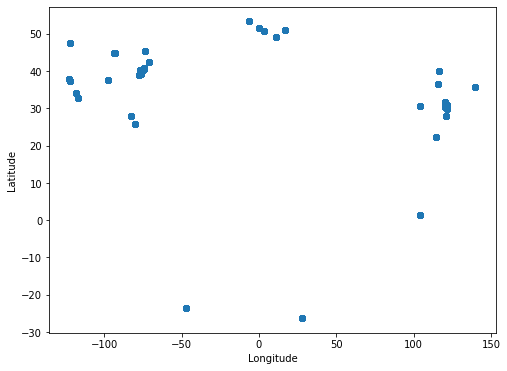

In [16]:
import json

with open('example_pcaps/activity_ips.txt', 'r') as f:
    IP_data = json.load(f)

def IP_to_lat(row):
    return float(IP_data[row["ip_src"]]["loc"].split(",")[0])

def IP_to_lon(row):
    return float(IP_data[row["ip_src"]]["loc"].split(",")[1])

# NOTE: Probably should just do this with a dataframe join.
copy_data = data.copy()
copy_data["lat"] = 0
copy_data["lon"] = 0

copy_data = copy_data[copy_data["ip_src"].notnull()]

copy_data["lat"] = copy_data.apply(IP_to_lat, axis=1)
copy_data["lon"] = copy_data.apply(IP_to_lon, axis=1)

lat_data = copy_data["lat"]
lon_data = copy_data["lon"]

plt.scatter(lon_data, lat_data)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Look up some of these IPs. What do you think this plot is a map of?

Now, let's cluster them. Take a few minutes to play with different numbers of clusters. What should the clusters represent? See if you can produce a good clustering. What should the clusters represent?

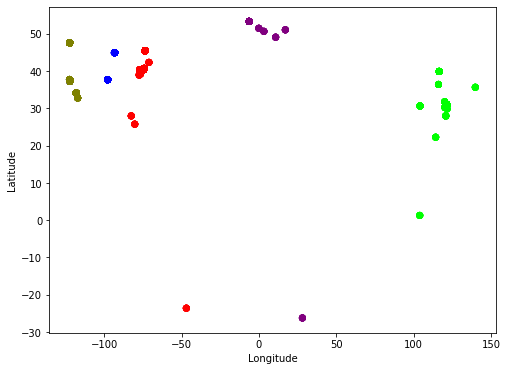

In [17]:
kmeans = KMeans(n_clusters=5)

# zip forms lat, long tuples
# list creates a list of all tuples
kmeans_data = list(zip(lat_data, lon_data))

# cluster the tuples
kmeans.fit(kmeans_data)
clusters = kmeans.predict(kmeans_data)

plt.scatter(lon_data, lat_data, c=clusters, cmap='brg')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## K-Means Failure Scenarios

Now, we'll examine a case where clustering performs poorly, despite there being seemingly good positions for these clusters.

On the X-axis, we will graph the source IPs of our data.
On the Y-axis, we will graph the total # of bytes sent by each IP.

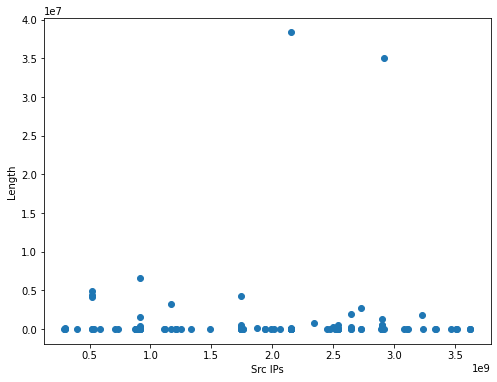

In [18]:
ip_src = data[data["ip_src_int"].notnull()]["ip_src_int"].unique()
ip_src.sort()
ip_src_bytes = data[data["ip_src_int"].notnull()].groupby("ip_src_int").sum()["length"]

plt.scatter(ip_src, ip_src_bytes)
plt.xlabel("Src IPs")
plt.ylabel("Length")
plt.show()

K-Means has a hard time producing a good clustering of the data. Because there are so many senders with a short connection, K-Means prefers to choose centroids near the bottom of the graph to minimize the total error.

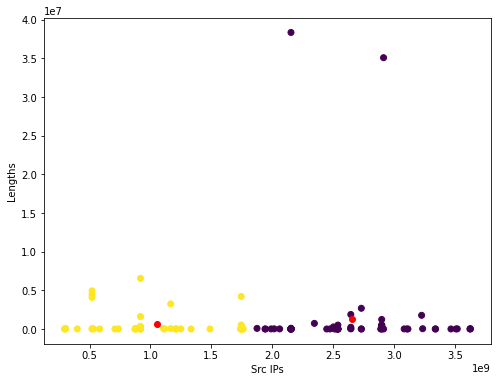

In [19]:
kmeans = KMeans(n_clusters=2)
X = list(zip(ip_src, ip_src_bytes))
kmeans.fit(X)
clusters = kmeans.predict(X)

plt.scatter(ip_src, ip_src_bytes, c=clusters)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], color='red')
plt.xlabel("Src IPs")
plt.ylabel("Lengths")
plt.show()

A simple modification to produce a better clustering would be to multiply all the lengths by a large constant. This way, the penalty of the outlying two points would be so great that K-means now prefers to choose a centroid near the two senders with large sending amounts.

In [20]:
kmeans = KMeans(n_clusters=2)
X_scaled = list(zip(ip_src, ip_src_bytes*1000))
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

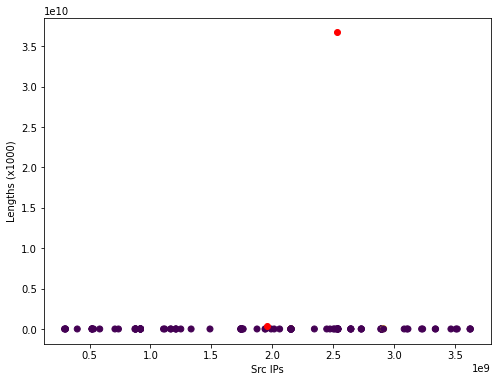

In [21]:
plt.scatter(ip_src, ip_src_bytes, c=clusters)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], color='red')
plt.xlabel("Src IPs")
plt.ylabel("Lengths (x1000)")
plt.show()

### Tuning k in k-Means Clustering


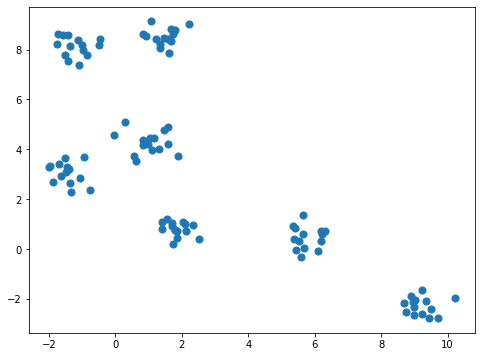

In [22]:
randint = np.random.randint(3, 10)
X, y_true = make_blobs(n_samples=100, centers=randint,cluster_std=0.4, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

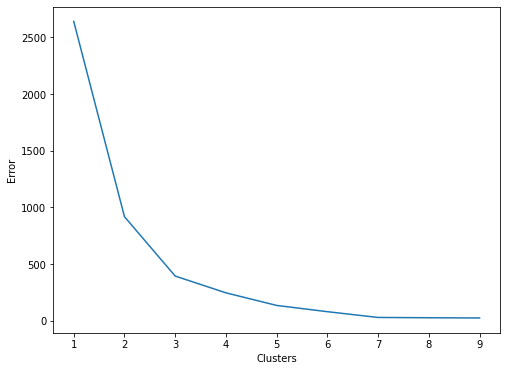

In [23]:
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import figure, show

guesses = []
guess_error_rates = []

guess = np.arange(1,10)

# make a k_means variable equal to KMeans with "guess" number of clusters (See above!)
# fit KMeans to the data "X"
for c in guess:
    k_means = KMeans(n_clusters=c)
    k_means.fit(X)

    guesses.append(c)
    guess_error_rates.append(k_means.inertia_)


ax = figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    
plt.plot(guesses, guess_error_rates)
plt.xlabel("Clusters")
plt.ylabel("Error")
plt.show()

## Density and Distribution-Based Clustering

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

X = list(zip(lon_data, lat_data))

dbscan = DBSCAN(min_samples=3)
dbscan.fit(X)
clusters = dbscan.labels_

In [ ]:
plt.scatter(lon_data, lat_data, c=clusters, cmap='brg')
plt.show()

### Gaussian Mixture Models

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(X)

plt.scatter(lon_data,lat_data, c=labels, cmap='brg')
plt.show()